# Retail Dataset Analysis

__Introduction:__
> This project focuses on the __[Online Retail II dataset](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci/data)__ from Kaggle, which contains retail transaction records from <br>
> a UK-based online retailer. The primary aim is to analyze the sales data to gain insights into customer <br>
> purchasing behavior and preferences. Predictive model will also be built to forecast customer preferences. <br>

## Preparations

#### Import Libraries And Dataset

In [55]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from fuzzywuzzy import fuzz
import math

In [2]:
# Import Dataset
df = pd.read_csv("online_retail_II.csv")

#### Useful Functions

In [3]:
# This is a function for plotting a graph with top ten values
def plot_top10_with_description(summary, column_sort, column_aggregate, ylabel, title, ascending=False):
    tmp_ = summary.sort_values(by=column_aggregate, ascending=ascending)[:10]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].bar(x=tmp_[column_sort], height=tmp_[column_aggregate])
    for label in ax[0].get_xticklabels():
        label.set_rotation(-45)
    ax[0].set_xlabel(column_sort)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)

    ax[1].axis('tight')
    ax[1].axis('off')
    table = ax[1].table(cellText=tmp_[[column_sort, 'Description']].values, colLabels=[column_sort, 'Description'], loc='center')

    for i in range(2):
        table.auto_set_column_width(i)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    plt.tight_layout()
    plt.show()
    del tmp_

In [4]:
# This is a function for calculating filtered mean within certain standard deviation
def filtered_mean(x, n_sd=2):
    t = np.array(x)
    mu = t.mean()
    sd = t.std()
    filtered_x = t[(t>=mu-sd*n_sd) & (t<=mu+sd*n_sd)]
    return filtered_x.mean()

## Data Pre-Processing

In [5]:
df.sample(5, random_state=1)            # print 5 sample rows of the dataset

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
416846,529196,85132B,CHARLIE AND LOLA TABLE TINS,1,2010-10-27 08:36:00,9.95,12537.0,Sweden
660775,547891,22029,SPACEBOY BIRTHDAY CARD,12,2011-03-28 10:14:00,0.42,13266.0,United Kingdom
703947,552232,23156,SET OF 5 MINI GROCERY MAGNETS,1,2011-05-06 15:54:00,4.13,NaN,United Kingdom
673555,549169,21034,REX CASH+CARRY JUMBO SHOPPER,3,2011-04-06 17:25:00,0.95,17906.0,United Kingdom
376048,525733,21035,SET/2 RED RETROSPOT TEA TOWELS,2,2010-10-06 16:17:00,2.95,17006.0,United Kingdom


We can see that the dataset consists of 8 columns. Notice that Customer ID of the 3rd sample is NaN, indicating that there exist NaN values in the dataset.

In [6]:
df.info()          # general info of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [7]:
df = df.astype({'Customer ID':'Int64'}, errors='ignore')
df = df.astype({'Customer ID':str}, errors='ignore')

In [8]:
##########################################################

In [9]:
print(f"Null values in column 'Description': {df['Description'].isnull().sum()}")
print(f"Null values in column 'Customer ID': {df['Customer ID'].isnull().sum()}")

Null values in column 'Description': 4382
Null values in column 'Customer ID': 0


We can see that Description and Customer ID contain NaN values. <br>
For Description, we can try to retrieve the information from other records with the same stockcode. <br>
&nbsp;&nbsp; (The description of the same product should be the same, while stockcode is an unique identifier of the product) <br>
For Customer ID, we can try to retrieve the information from other records with the same invoice. <br>
&nbsp;&nbsp;(an invoice is the purchasing of the same person)

In [10]:
df['Description'] = df['Description'].str.strip()       # Remove leading and trailing spaces       
df['Description'] = df['Description'].str.replace(r'\s+', ' ', regex=True)    # Replace consecutive spaces with a single space
df['Description'] = df['Description'].where(df['Description'].str.contains('[a-zA-Z]', regex=True), np.nan) # Replace entries with no letters with NaN

In [11]:
count_unique_description_n = df['Description'].groupby(df['StockCode']). \
                        aggregate(lambda x: x.dropna().unique())
sc2des = count_unique_description_n.to_dict()
count_unique_description_n = count_unique_description_n.apply(len).sort_values(ascending=False)
print(f"Number of StockCodes with multiple description (nan removed): {sum(count_unique_description_n > 1)}")
print(count_unique_description_n.head())

Number of StockCodes with multiple description (nan removed): 1153
StockCode
20713    9
23084    7
22423    7
22734    7
21181    6
Name: Description, dtype: int64


In [12]:
# look at the top 5 stockcodes with the most distinct description
for sc in count_unique_description_n.index[:5]:
    print(f"Unique Description of StockCode {sc} (without nan):")
    print(sc2des[sc], "\n")

Unique Description of StockCode 20713 (without nan):
['JUMBO BAG OWLS' 'missing' 'wrongly marked. 23343 in box'
 'wrongly coded-23343' 'found' 'Found' 'wrongly marked 23343'
 'Marked as 23343' 'wrongly coded 23343'] 

Unique Description of StockCode 23084 (without nan):
['RABBIT NIGHT LIGHT' 'temp adjustment'
 'allocate stock for dotcom orders ta'
 'add stock to allocate online orders' 'for online retail orders' 'Amazon'
 'website fixed'] 

Unique Description of StockCode 22423 (without nan):
['REGENCY CAKESTAND 3 TIER' 'smashed' 'damaged' 'broken, uneven bottom'
 'wonky bottom/broken' 'faulty' 'damages'] 

Unique Description of StockCode 22734 (without nan):
['SET OF 6 RIBBONS VINTAGE CHRISTMAS'
 'Carton qnty was 216 not 144 as stat' 'amazon adjustment' 'amendment'
 'amazon' 'amazon sales' 'FOUND'] 

Unique Description of StockCode 21181 (without nan):
['PLEASE ONE PERSON METAL SIGN' 'missing' 'on cargo order' 'adjustment'
 'check' 'dotcom'] 



Here are some findings: <br>
- The true description of a stockcode would be consisted of uppercase letters and number. <br>
while descriptions with lowercase letters are remarks of the products (e.g. smashed, found)
-  There exist multiple true descriptions for a stockcode (e.g. 21181) with slight difference.

We will address the first finding first. <br>
For StockCode with multiple description, we will keep the longest (most informative) and relevent (by using similarity) one.

In [13]:
def list_upper(arr):
    if arr.size == 0:
        return arr
    return arr[np.vectorize(lambda x: not any(c.islower() for c in x))(arr)]

for sc in sc2des.keys():
    sc2des[sc] = list_upper(sc2des[sc])

In [14]:
df_tmp = pd.DataFrame([(key, value) for key, value in sc2des.items()], columns=['StockCode', 'Description'])
df_tmp2 = df_tmp[df_tmp['Description'].apply(len)>1].reset_index(drop=True)

In [15]:
def reduce_similar(arr):
    if len(arr) < 2:
        return arr
    first = arr[0]
    remaining = np.array(reduce_similar(arr[1:], ))
    similarity = np.vectorize(lambda x: fuzz.token_sort_ratio(first, x))(remaining)
    similar = remaining[similarity>=40]
    not_similar = remaining[similarity<40]
    return list(not_similar) + list([max(np.append(similar, first), key=len)])

In [16]:
for sc in sc2des.keys():
    sc2des[sc] = list(map(str, reduce_similar(sc2des[sc])))

In [17]:
df_tmp = pd.DataFrame([(key, value) for key, value in sc2des.items()], columns=['StockCode', 'Description'])
df_tmp[df_tmp['Description'].apply(len)>1]

,StockCode,Description
164,17027A,"[MISSING, INCENSE BAZAAR CANNABIS]"
255,20681,"[MIA, PINK POLKADOT CHILDRENS UMBRELLA]"
588,21090,"[WET/MOULDY, SET/6 COLLAGE PAPER PLATES]"
1046,21618,"[CHECK, 4 WILDFLOWER BOTANICAL CANDLES]"
1050,21622,"[POSSIBLE DAMAGES OR LOST?, VINTAGE UNION JACK..."
1173,21749,"[MIA, LARGE RED RETROSPOT WINDMILL]"
1245,21830,"[MERCHANT CHANDLER CREDIT ERROR, STO, ASSORTED..."
1353,21967,"[MIA, PACK OF 12 SKULL TISSUES]"
2053,22734,"[FOUND, SET OF 6 RIBBONS VINTAGE CHRISTMAS]"
2146,22829,"[SWEETHEART WIRE WALL TIDY, BROCANTE SHELF WIT..."


The remaining ones needed to be cleaned manually

In [18]:
remove_words = ['CHECK', 'DAMAGED', 'MIA', 'FBA', 'AMAZON', 'FOUND', 'WET/MOULDY', 'STO', 'MISSING', 'DOTCOM SETS']
for sc in sc2des.keys():
    sc2des[sc] = [x for x in sc2des[sc] if not x in remove_words]

In [19]:
df_tmp = pd.DataFrame([(key, value) for key, value in sc2des.items()], columns=['StockCode', 'Description'])
df_tmp[df_tmp['Description'].apply(len)>1]

,StockCode,Description
1050,21622,"[POSSIBLE DAMAGES OR LOST?, VINTAGE UNION JACK..."
1245,21830,"[MERCHANT CHANDLER CREDIT ERROR, STO, ASSORTED..."
2146,22829,"[SWEETHEART WIRE WALL TIDY, BROCANTE SHELF WIT..."
2149,22832,"[BROCANTE SHELF WITH HOOKS, SWEETHEART WIRE WA..."
3362,47587A,"[12'S SOLD AS 1?, PINK FAIRY CAKE COASTER]"


In [20]:
sc2des['21622'] = ['VINTAGE UNION JACK CUSHION COVER']
sc2des['21830'] = ['ASSORTED CREEPY CRAWLIES']
sc2des['22829'] = ['SWEETHEART WIRE WALL TIDY' + ' / ' + 'BROCANTE SHELF WITH HOOKS']     # cannot judge
sc2des['22832'] = ['BROCANTE SHELF WITH HOOKS', 'SWEETHEART WIRE WALL TIDY']    # cannot judge
sc2des['22829'] = ['PINK FAIRY CAKE COASTER']

In [21]:
# remove stockcode with no description
for sc in list(sc2des.keys()):
    if len(sc2des[sc]) == 0:
        del sc2des[sc]
    else:
        sc2des[sc] = sc2des[sc][0]      # change list to str

In [22]:
df['Description'] = df['StockCode'].apply(lambda x: sc2des.get(x, np.nan))

Do the same thing to 'Customer ID' 

In [23]:
count_unique_cid_n = df['Customer ID'].groupby(df['Invoice']). \
                        aggregate(lambda x: x.dropna().unique())

In [24]:
print("Number of Invoice with multiple cid: ", sum(count_unique_cid_n.apply(len) > 1))

Number of Invoice with multiple cid:  0


Invoice - cid is indeed 1 to 1 mapping. Good news

In [25]:
inv2cid = count_unique_cid_n.to_dict()
for inv in list(inv2cid.keys()):
    inv2cid[inv] = inv2cid[inv][0]
    if inv2cid[inv] == '<NA>':
        del inv2cid[inv]

In [26]:
df['Customer ID'] = df['Invoice'].apply(lambda x: inv2cid.get(x, np.nan))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062079 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   object 
 7   Country      1067371 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 65.1+ MB


In [28]:
df = df.dropna()      # remove nan

In [29]:
######################################################################################

Next, we can check the range of Quantity and Price

In [30]:
df.describe()

,Quantity,Price
count,820554.000000,820554.000000
mean,12.408132,3.075432
std,189.246340,14.290326
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Something interesting about the figures:
1. some quantities are below 0 
2. some prices are equal to 0

we may want to take a look at these records

In [31]:
df[df['Quantity']<=0].sample(5, random_state=1234)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379212,C525936,22553,PLASTERS IN TIN SKULLS,-2,2010-10-07 17:08:00,1.65,17706,United Kingdom
1022719,C578355,22178,VICTORIAN GLASS HANGING T-LIGHT,-3,2011-11-24 10:13:00,1.95,14397,United Kingdom
795562,C560540,21917,SET 12 KIDS WHITE CHALK STICKS,-1,2011-07-19 12:26:00,0.42,12415,Australia
795033,C560474,21429,RED GINGHAM ROSE JEWELLERY BOX,-2,2011-07-19 10:46:00,1.95,12705,Germany
408318,C528476,22840,"CAKE TIN, ROUND, VINTAGE RED,CREAM",-1,2010-10-22 12:01:00,7.95,15296,United Kingdom


The descriptions of these records are normal products, perhaps these are refund records.

In [32]:
df[df['Price']==0].sample(5, random_state=1234)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
392008,527084,22630,DOLLY GIRL LUNCH BOX,64,2010-10-14 15:33:00,0.0,14646,Netherlands
840209,564651,21786,RAIN HAT WITH RED SPOTS,144,2011-08-26 14:19:00,0.0,14646,Netherlands
572531,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.0,16858,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.0,14258,United Kingdom


Perhaps the records with Price == 0 are giveaways. <br>
Notice that the 3rd sample's StockCode is not numeric and the Description writes "Manual", <br>
We may want to take a look at the records with non-numerical StockCode.

In [33]:
df[df['StockCode'].apply(lambda x: str.isalpha(x))].sample(5, random_state=1234)      # find all non-numerical StockCode

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
778232,559134,POST,POSTAGE,5,2011-07-06 13:14:00,18.0,12700,France
872075,567191,POST,POSTAGE,3,2011-09-19 09:15:00,18.0,12562,France
445664,531824,POST,POSTAGE,2,2010-11-09 17:37:00,28.0,12782,Portugal
644230,546479,POST,POSTAGE,3,2011-03-14 11:38:00,18.0,12682,France
981034,575629,POST,POSTAGE,1,2011-11-10 13:34:00,18.0,12599,France


The Description of these records are "POSTAGE", "Discount" and "Manual", which are not usual purchasing records. <br>
Notice that the Invoice of the 3rd sample is not numerical. We may want to take at these cases later.<br><br>
In the next step, we want to see a list of all Description of records with StockCode consist of alphabets only or alphabets and digits

In [34]:
# unique Description of records with StockCode consist of alphabets and digits
df[['StockCode', 'Description']][df['StockCode'].apply(lambda x: not str.isnumeric(x))].drop_duplicates().sort_values('StockCode').head(10)

,StockCode,Description
11727,10123C,HEARTS WRAPPING TAPE
273353,10123G,ARMY CAMO WRAPPING TAPE
130361,10124A,SPOTS ON RED BOOKCOVER TAPE
203252,10124G,ARMY CAMO BOOKCOVER TAPE
14820,15044A,PINK PAPER PARASOL
3164,15044B,BLUE PAPER PARASOL
28672,15044C,PURPLE PAPER PARASOL
3165,15044D,RED PAPER PARASOL
613,15056BL,EDWARDIAN PARASOL BLACK
614,15056N,EDWARDIAN PARASOL NATURAL


The alphabet at the end of the StockCode indicates the variations of a product. <br><br>
Also check the StockCode begining with alphabets:

In [35]:
# unique Description of records with StockCode consist begin alphabets
df[['StockCode', 'Description']][df['StockCode'].apply(lambda x: str.isalpha(x[0]))].drop_duplicates().sort_values('StockCode')

,StockCode,Description
9292,C2,CARRIAGE
842968,DOT,DOTCOM POSTAGE
62299,PADS,PADS TO MATCH ALL CUSHIONS
89,POST,POSTAGE
377066,SP1002,KID'S CHALKBOARD/EASEL


These are some special transaction types, which are not the main focus of this project.

In [36]:
# records with Invoice consist of alphabets and digits
df[df['Invoice'].apply(lambda x: not str.isnumeric(x))].sample(5, random_state=1234)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379212,C525936,22553,PLASTERS IN TIN SKULLS,-2,2010-10-07 17:08:00,1.65,17706,United Kingdom
1022719,C578355,22178,VICTORIAN GLASS HANGING T-LIGHT,-3,2011-11-24 10:13:00,1.95,14397,United Kingdom
795562,C560540,21917,SET 12 KIDS WHITE CHALK STICKS,-1,2011-07-19 12:26:00,0.42,12415,Australia
795033,C560474,21429,RED GINGHAM ROSE JEWELLERY BOX,-2,2011-07-19 10:46:00,1.95,12705,Germany
408318,C528476,22840,"CAKE TIN, ROUND, VINTAGE RED,CREAM",-1,2010-10-22 12:01:00,7.95,15296,United Kingdom


In [37]:
# a summary of records with Invoice consist of alphabets and digits
df[df['Invoice'].apply(lambda x: not str.isnumeric(x))].describe()

,Quantity,Price
count,18085.000000,18085.000000
mean,-26.260326,5.294026
std,835.544186,61.744599
min,-80995.000000,0.030000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,8142.750000


All records with Invoice consist of digits and alphabets have Quantiry <= -1. <br>
They are probably refund cases. 

Let's take a deeper look into the cases with negative Quantity. <br>
We take this record as a sample:

We try to find if this customer has bought a "PINK  SPOTTY CUP" before:

In [38]:
tmp = df[df['Customer ID'] == '17511']
tmp[tmp['Description'] == 'PINK  SPOTTY CUP']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


The customer has brought the cups for 3 times. <br>
The refunding happens between the 2nd and 3rd purchases. <br>

Let's look at another case:

In [39]:
tmp = df[df['Customer ID'] == '15755']
tmp[tmp['StockCode'] == '23660']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1036173,579467,23660,HENRIETTA HEN MUG,12,2011-11-29 14:57:00,1.65,15755,United Kingdom
1065544,C581465,23660,HENRIETTA HEN MUG,-2,2011-12-08 18:59:00,1.65,15755,United Kingdom


We can almost confirm that the records with negative Quantity are refundings. (Besides those with special StockCode)

The goal of this project is to draw insights in the sales records. <br>
The refunding cases, special transactions and giveaways are not the focus. <br>
The following cases would be excluded: 
1. Price <= 0
2. StockCode starts with alphabets
3. NaN (Done)

In [40]:
df = df[df['StockCode'].apply(lambda x: not str.isalpha(x[0]))]       # remove StockCode starts with alphabets
df = df[df['Price'] > 0]                                              # remove Price <= 0

In [41]:
df = df.sort_values(by=['Customer ID', 'StockCode', 'Price', 'Quantity', 'InvoiceDate'],
               ascending=[True, True, True, True, False]).reset_index(drop=True)
df['Accumulated'] = 0

In [42]:
c_c, c_s = '', ''
c_p, accu = 0, 0
for i in tqdm(range(df.shape[0])):
    row_i = df.loc[i]
    is_next = row_i['StockCode'] != c_s or row_i['Customer ID'] != c_c or row_i['Price'] != c_p
    if is_next:
        accu = row_i['Quantity']
        df.loc[i, 'Accumulated'] = row_i['Quantity']
        c_c, c_s = row_i['Customer ID'], row_i['StockCode']
        c_p = row_i['Price']
    else:
        if accu < 0:
            accu += row_i['Quantity']
            df.loc[i, 'Accumulated'] = accu
            #df.loc[i, 'Quantity'] = accu
        else:
            df.loc[i, 'Accumulated'] = row_i['Quantity']

        #df.loc[i, 'Accumulated'] = row_i['Quantity'] + accu
        #accu += row_i['Quantity']

  0%|          | 0/818179 [00:00<?, ?it/s]

In [43]:
df.loc[330:350]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Accumulated
330,C490283,20747,PICCADILLY TEA SET,-1,2009-12-04 12:49:00,14.95,12349,Italy,-1
331,C490283,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,-1,2009-12-04 12:49:00,2.95,12349,Italy,-1
332,577609,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,6,2011-11-21 09:51:00,2.95,12349,Italy,5
333,529344,20985,HEART CALCULATOR,12,2010-10-28 08:23:00,1.25,12349,Italy,12
334,577609,21086,SET/6 RED SPOTTY PAPER CUPS,12,2011-11-21 09:51:00,0.65,12349,Italy,12
335,506394,21086,SET/6 RED SPOTTY PAPER CUPS,12,2010-04-29 13:20:00,0.65,12349,Italy,12
336,577609,21136,PAINTED METAL PEARS ASSORTED,16,2011-11-21 09:51:00,1.69,12349,Italy,16
337,506394,21218,RED SPOTTY BISCUIT TIN,6,2010-04-29 13:20:00,3.75,12349,Italy,6
338,C490283,21231,SWEETHEART CERAMIC TRINKET BOX,-1,2009-12-04 12:49:00,1.25,12349,Italy,-1
339,529344,21231,SWEETHEART CERAMIC TRINKET BOX,24,2010-10-28 08:23:00,1.25,12349,Italy,23


In [44]:
df = df[df['Accumulated']>0]
df = df.drop(columns=['Quantity'])
df = df.rename(columns={'Accumulated': 'Quantity'})

For easier investigation, the product of Price and Quantity (TotalPrice) is added as a new column.

In [45]:
df['TotalPrice'] = df['Price'] * df['Quantity']

In [46]:
df.reset_index(drop=True, inplace=True)

## EDA

In this section, we will investigate how price, product type, date and other factors affect customers' preference. 

#### Products related

###### Collaspse

In [47]:
summary = df.groupby(['StockCode', 'Customer ID'])['Quantity'].count().reset_index()
summary = summary.groupby('StockCode')['Customer ID'].count().sort_values(ascending=False).reset_index()
summary.rename(columns={'Customer ID':'# of Customers Purchased'}, inplace=True)

In [48]:
tmp1 = df.groupby('StockCode')['Price'].idxmax().values

In [49]:
summary = pd.merge(summary, df[['StockCode', 'Description']].loc[tmp1], on='StockCode')

######

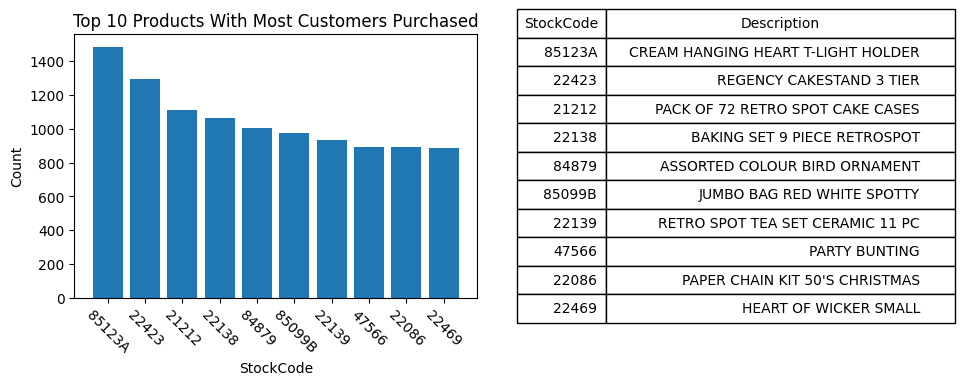

In [50]:
plot_top10_with_description(summary,'StockCode' , '# of Customers Purchased', 'Count', 'Top 10 Products With Most Customers Purchased')

The figure above shows the 10 products with the most customers purchased. <br>
From the list, we can see that most of them are bakery related items or little decorations.

Next, we want to see the items with highest and lowest unit price.

###### Collapse

In [51]:
tmp1 = df.groupby('StockCode')['Price'].max()
summary = pd.merge(summary, tmp1, on='StockCode')
del tmp1

######

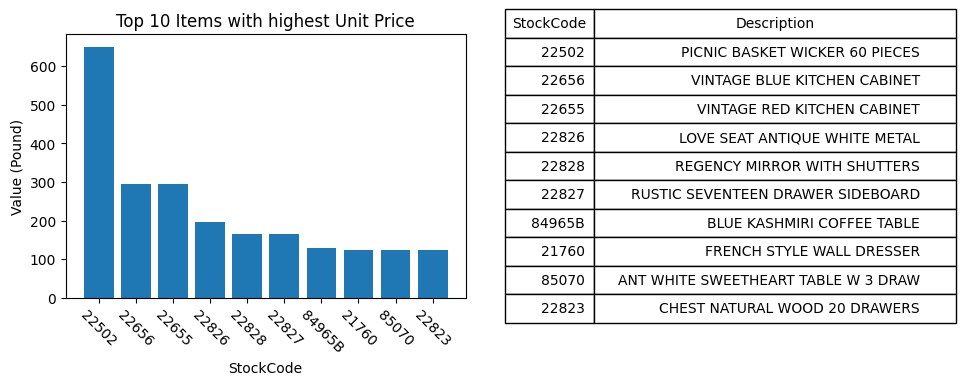

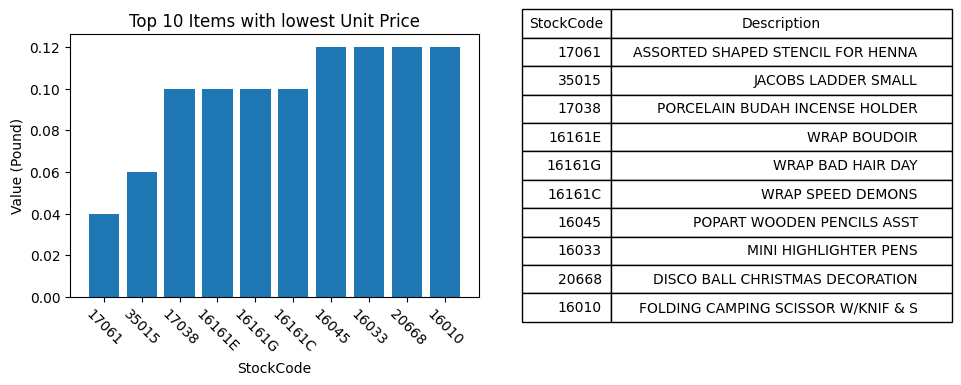

In [52]:
plot_top10_with_description(summary,'StockCode', 'Price', 'Value (Pound)', 'Top 10 Items with highest Unit Price', False)
plot_top10_with_description(summary,'StockCode', 'Price', 'Value (Pound)', 'Top 10 Items with lowest Unit Price', True)

The items with the highest unit prices are mainly large furnitures (with the 1st one being an exception: a set of 60 picnic baskets) <br>
Meanwhile, the items with the lowest unit prices are mainly stationaries or little decorations. 

If we plot log(Quantity) against log(Price):

###### Collapse

In [53]:
tmp1 = df.groupby('StockCode')['Quantity'].sum().reset_index()
tmp1.rename(columns={'Quantity':'Total #'}, inplace=True)
summary = pd.merge(summary, tmp1, on='StockCode')
del tmp1

In [56]:
X = summary['Total #'].apply(math.log).to_numpy().reshape((-1,1))
y = summary['Price'].apply(math.log).to_numpy().reshape((-1,1))
model = LinearRegression()
model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


######

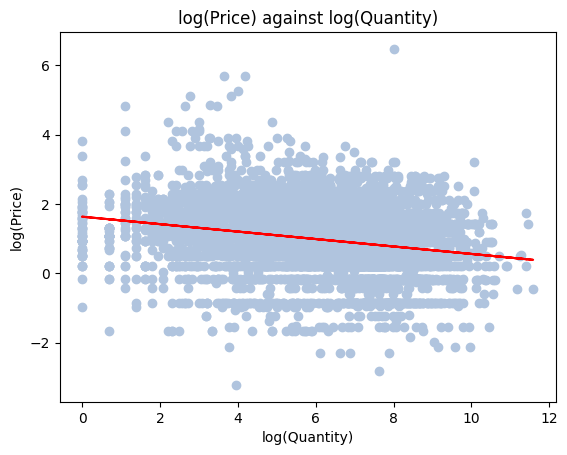

In [57]:
plt.scatter(x=X, y=y, color='lightsteelblue')
plt.plot(X, model.predict(X), color='red')
plt.xlabel('log(Quantity)')
plt.ylabel('log(Price)')
plt.title('log(Price) against log(Quantity)')
plt.show()

In the graph above, each point is the __log max unit price__ vs __log total quantity sold of an item__. <br>
The reason of using log is to scale down some extreme data points. <br><br>

The red line is a regression line of the points. <br>
Its downward slope implies that items with higher unit prices tend to sell less, which matches our intuition.

#### Extreme Cases (Invoices & Transactions)

First, we take a look at the distributions of Total value of each invoice and each transaction. 

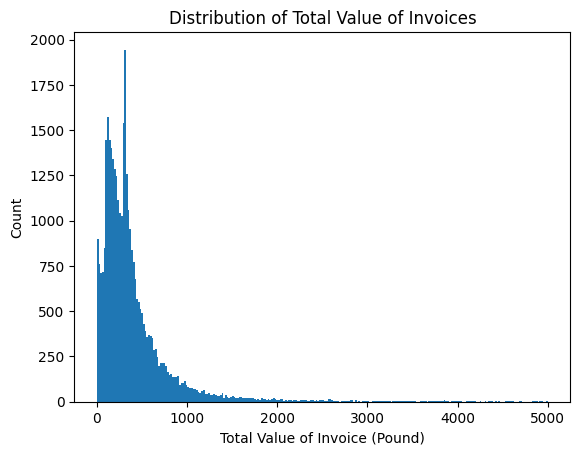

filtered mean: 372.83


In [58]:
tmp = df.groupby('Invoice')['TotalPrice'].sum().reset_index()
plt.hist(tmp['TotalPrice'], bins='auto', range=(0,5000))
plt.ylabel('Count')
plt.xlabel('Total Value of Invoice (Pound)')
plt.title('Distribution of Total Value of Invoices')
plt.show()
print(f"filtered mean: {round(filtered_mean(tmp['TotalPrice']), 2)}")



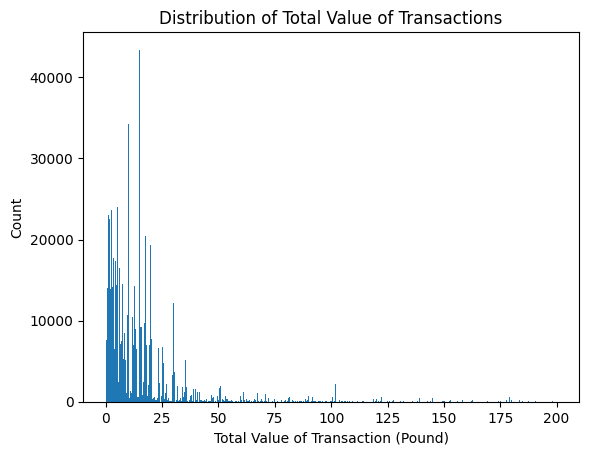

filtered mean: 16.72


In [59]:
plt.hist(df['TotalPrice'], bins='auto', range=(0,200))
plt.ylabel('Count')
plt.xlabel('Total Value of Transaction (Pound)')
plt.title('Distribution of Total Value of Transactions')
plt.show()
print(f"filtered mean: {round(filtered_mean(df['TotalPrice']), 2)}")

The distributions of the graphs above are similar in shapes, (concentrated at smaller values and right-skewed) <br>
with filtered mean of 375.13 (Invoice) and 16.71 (Transaction). <br>
Most Values are below 1000 (Invoice) and 50 (Transaction). <br><br>

Notice that some extreme data points are truncated. We will now take a look at those points:


In [60]:
print("#### Top 10 Transactions With The Highest Total Value ####")
df.sort_values(by='TotalPrice', ascending=False).head(10)

#### Top 10 Transactions With The Highest Total Value ####


,Invoice,StockCode,Description,InvoiceDate,Price,Customer ID,Country,Quantity,TotalPrice
379370,556444,22502,PICNIC BASKET WICKER 60 PIECES,2011-06-10 15:28:00,649.50,15098,United Kingdom,60,38970.00
466579,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2010-11-04 11:36:00,1.69,15838,United Kingdom,9360,15818.40
763601,511465,15044A,PINK PAPER PARASOL,2010-06-08 12:59:00,2.55,18008,United Kingdom,3500,8925.00
678097,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,2011-09-20 11:05:00,5.06,17450,United Kingdom,1412,7144.72
455000,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,2011-01-11 12:55:00,2.10,15749,United Kingdom,3114,6539.40
466578,525968,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,2010-10-08 10:10:00,1.66,15838,United Kingdom,3120,5179.20
304129,573003,23084,RABBIT NIGHT LIGHT,2011-10-27 12:11:00,2.08,14646,Netherlands,2400,4992.00
455005,550461,85123A,CREAM HANGING HEART T-LIGHT HOLDER,2011-04-18 13:20:00,2.40,15749,United Kingdom,1930,4632.00
677861,524181,21622,VINTAGE UNION JACK CUSHION COVER,2010-09-27 16:59:00,6.89,17450,United Kingdom,648,4464.72
756157,558526,23173,REGENCY TEAPOT ROSES,2011-06-30 11:01:00,8.15,17949,United Kingdom,540,4401.00


The top record shows the purchase of 60 sets of 60 picnic basket wickers. It’s possible that the quantity <br>
of 60 refers to a set of 60 rather than 60 sets of 60. Unfortunately, we don't have any way to distinguish <br>
between these interpretations, so we will keep this record unchanged. <br>
<br>
The next 2-3 records involve the purchase of 9,360 light holders and 3,500 paper parasols, respectively. <br>
Although the unit prices of these items are not high, <br>
the large quantities purchased result in a significantly high total price. <br>

In [61]:
print("#### Top 10 Invoices With The Highest Total Value ####")
tmp1 = df.groupby('Invoice')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
tmp1.rename(columns={'TotalPrice':'Total Value'}, inplace=True)
tmp2 = df.groupby('Invoice')['TotalPrice'].count().reset_index()
tmp2.rename(columns={'TotalPrice':'# of transactions'}, inplace=True)
pd.merge(tmp1, tmp2, on='Invoice').head(10)

#### Top 10 Invoices With The Highest Total Value ####


,Invoice,Total Value,# of transactions
0,493819,43555.10,93
1,556444,38970.00,1
2,524181,33167.80,13
3,537659,31770.98,18
4,567423,27872.80,11
5,526934,26007.08,15
6,515944,22863.36,17
7,556917,22668.43,138
8,572209,22206.00,7
9,567381,22104.80,12


Most Invoices in the table have a number of transactions greater than 10. However, note that the <br>
second row from the top refers to the picnic basket wickers purchase mentioned in the previous section. <br>
A single transaction accounts for the second highest amount overall. This is an extreme case.

#### Customer Behavior

In [62]:
tmp = df[['Customer ID', 'StockCode']].drop_duplicates()
tmp = tmp.groupby('Customer ID')['StockCode'].count()
print(f"On average, a customer have bought {round(tmp.mean(), 2)} different products")

On average, a customer have bought 81.65 different products


##### Best Customers

Next, we will look at the best customers.

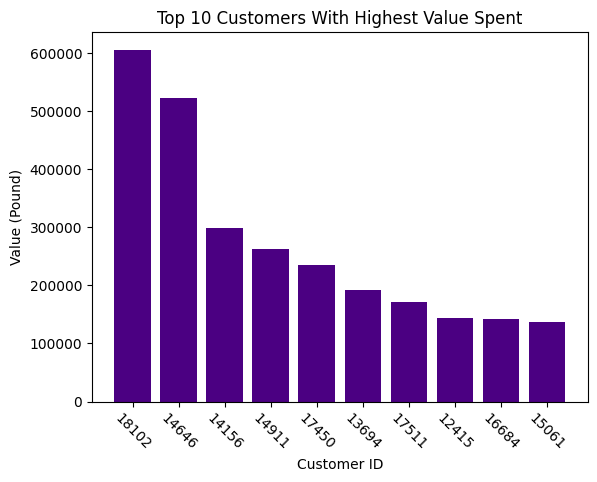

In [63]:
tmp = df.groupby('Customer ID')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
tmp.rename(columns={'TotalPrice':'Total Value Spent'}, inplace=True)
plt.bar(x=tmp['Customer ID'][:10], height=tmp['Total Value Spent'][:10], color="indigo")
plt.title('Top 10 Customers With Highest Value Spent')
plt.ylabel('Value (Pound)')
plt.xlabel('Customer ID')
plt.xticks(rotation=-45)
plt.show()

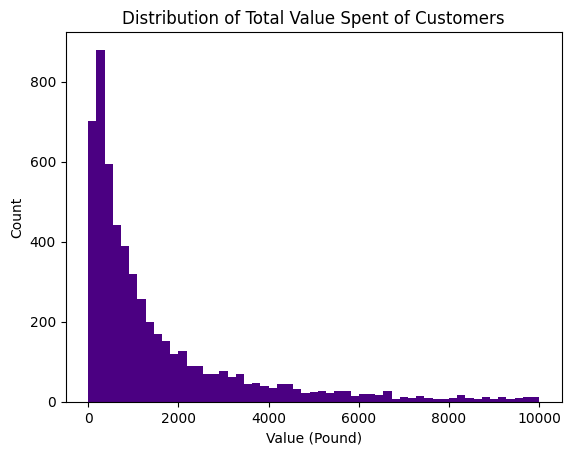

filtered mean: 2029.76


In [64]:
plt.hist(x=tmp['Total Value Spent'], bins='auto', range=(0,10000), color='indigo')
plt.title('Distribution of Total Value Spent of Customers')
plt.ylabel('Count')
plt.xlabel('Value (Pound)')
plt.show()
print(f"filtered mean: {round(filtered_mean(tmp['Total Value Spent']), 2)}")

The filtered mean of all customers' total spending is 2033.66, meanwhile the spending of the top 10 costumers are way high (>100000). <br>


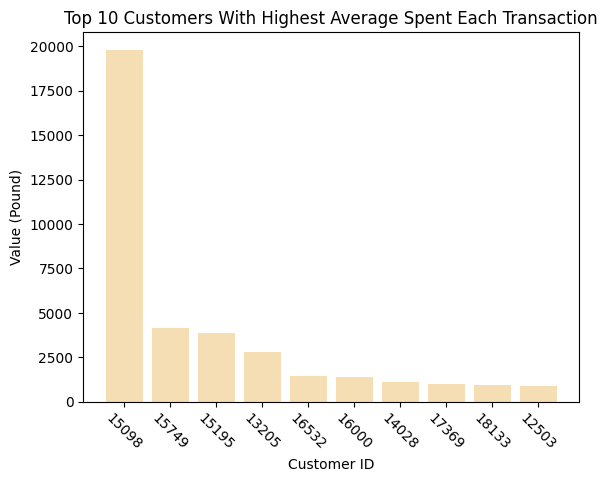

In [65]:
tmp = df.groupby('Customer ID')['TotalPrice'].mean().reset_index().sort_values(by='TotalPrice', ascending=False)
tmp.rename(columns={'TotalPrice':'Average Value Spent Each Transaction'}, inplace=True)
plt.bar(x=tmp['Customer ID'][:10], height=tmp['Average Value Spent Each Transaction'][:10], color="wheat")
plt.title('Top 10 Customers With Highest Average Spent Each Transaction')
plt.ylabel('Value (Pound)')
plt.xlabel('Customer ID')
plt.xticks(rotation=-45)
plt.show()

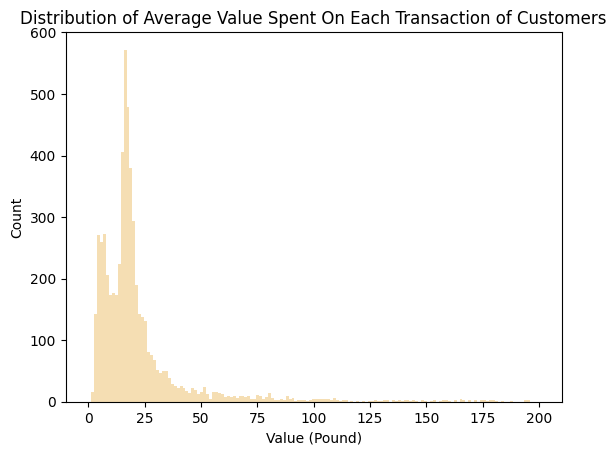

filtered mean: 26.46


In [66]:
plt.hist(x=tmp['Average Value Spent Each Transaction'], bins='auto', range=(0,200), color='wheat')
plt.title('Distribution of Average Value Spent On Each Transaction of Customers')
plt.ylabel('Count')
plt.xlabel('Value (Pound)')
plt.show()
print(f"filtered mean: {round(filtered_mean(tmp['Average Value Spent Each Transaction']), 2)}")

The filtered mean of all customers' Average spending on each transaction is 26.51, meanwhile the spending of the top 2 costumers exceeded 2500. 
<br><br>
From the information above, we know that some customers buy way more than the others.


##### Repeatedly Buying

Next, we will see if customers will buy the same products again

In [67]:
tmp = df[['Customer ID', 'Invoice', 'StockCode']].drop_duplicates()
tmp1 = tmp[tmp[['Customer ID', 'StockCode']].duplicated()]

In [68]:
print(f"Ratio of Customers buying the same items again: {round(len(tmp1['Customer ID'].unique())/len(df['Customer ID'].unique()), 2)}")
print(f"On average, Customers purchase an item {round(tmp.groupby(['Customer ID', 'StockCode'])['Invoice'].count().mean(), 2)} times.")

Ratio of Customers buying the same items again: 0.66
On average, Customers purchase an item 1.59 times.


Around 2/3 of the customers will purchase an item again. <br>
On average, an item would be purchased 1.59 times by the same customer. <br>
From these informations, we know that customers will purchase the same items after their first purchases.

##### Buying Variations

Some products have variances (those StockCode end with alphabet). <br>
We will see if customers would buy the variances after they brought one of them.

###### Collapse

In [69]:
tmp = df[['Invoice', 'StockCode']].copy()
tmp['StockCode_F'] = tmp['StockCode'].apply(lambda x: x[:-1] if str.isalpha(x[-1]) else "-")
tmp['StockCode_L'] = tmp['StockCode'].apply(lambda x: x[-1] if str.isalpha(x[-1]) else "-")

In [70]:
func1 = lambda x: len(x.unique())
tmp = tmp.groupby(['Invoice', 'StockCode_F'])['StockCode_L'].agg(func1).reset_index()
del func1
tmp.rename(columns={'StockCode_L':'Count Unique'}, inplace=True)
tmp['Count Unique'] = tmp['StockCode_F'].apply(str.isnumeric)*tmp['Count Unique']

In [71]:
func2 = lambda x: any(x>0)
func3 = lambda x: any(x>1)
tmp1 = tmp.groupby('Invoice')['Count Unique'].agg(func2).reset_index()
tmp2 = tmp.groupby('Invoice')['Count Unique'].agg(func3).reset_index()

In [72]:
x = round(tmp2['Count Unique'].sum()*100/tmp1['Count Unique'].sum(), 2)

######

In [73]:
print(f"{x}% of Invoices involve buying multiple types of IWV, given that the Invoices contain IWV.")
print("(IWV: Item With Variance)")

40.39% of Invoices involve buying multiple types of IWV, given that the Invoices contain IWV.
(IWV: Item With Variance)


When customers are buying some items with variance, there are decent chance that they will buy multiple types of the items.

##### Products In The Same Invoice

The mean and sd of different products:

In [74]:
tmp = df.groupby('StockCode')['Price'].max()
print(f"Mean Price of Products: {round(tmp.mean(), 2)}")
print(f"SD of Price of Products: {round(tmp.std(), 2)}")
print("(Price means the max price of a product)")

Mean Price of Products: 4.84
SD of Price of Products: 13.88
(Price means the max price of a product)


Next, we will take a look at the SD of product price within invoices.

In [75]:
tmp = df.groupby('Invoice')['Price'].std()
print(f"Mean of SD of product price within the same invoice: {round(tmp.mean(), 2)}")

Mean of SD of product price within the same invoice: 2.57


Which is much smaller than the SD of Price of Products (13.86), <br>
suggesting that customers tend to buy products of similar price in a single invoice. 

Let's randomly sample a customer:

In [76]:
df[df['Customer ID'] == df['Customer ID'].sample(random_state=1234).values[0]].sample(10, random_state=1234)

,Invoice,StockCode,Description,InvoiceDate,Price,Customer ID,Country,Quantity,TotalPrice
424630,551391,22974,CHILDRENS DOLLY GIRL MUG,2011-04-28 12:06:00,1.65,15514,United Kingdom,6,9.90
424506,505641,21877,HOME SWEET HOME MUG,2010-04-23 14:10:00,1.25,15514,United Kingdom,12,15.00
424580,538809,22722,SET OF 6 SPICE TINS PANTRY DESIGN,2010-12-14 12:17:00,3.95,15514,United Kingdom,8,31.60
424579,522907,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2010-09-17 13:08:00,8.50,15514,United Kingdom,3,25.50
424678,535313,84870C,GREEN GEISHA GIRL,2010-11-25 14:53:00,3.75,15514,United Kingdom,6,22.50
424564,522907,22496,SET OF 2 ROUND TINS DUTCH CHEESE,2010-09-17 13:08:00,2.95,15514,United Kingdom,3,8.85
424639,545637,22988,SOLDIERS EGG CUP,2011-03-04 12:16:00,1.25,15514,United Kingdom,48,60.00
424635,538327,22976,CIRCUS PARADE CHILDRENS EGG CUP,2010-12-10 13:58:00,1.25,15514,United Kingdom,36,45.00
424562,535313,22482,BLUE TEA TOWEL CLASSIC DESIGN,2010-11-25 14:53:00,1.25,15514,United Kingdom,12,15.00
424545,522907,22301,COFFEE MUG CAT + BIRD DESIGN,2010-09-17 13:08:00,2.55,15514,United Kingdom,6,15.30


We can see that the customer is buying products of >3 pounds with one exception (6.95) only. <br>

#### Seasonal and Regional Factors

In this section, we will investigate how total sales vary by date and country.

In [77]:
df['Year'] = df['InvoiceDate'].apply(lambda x: int(x[:4]))
df['Month'] = df['InvoiceDate'].apply(lambda x: int(x[5:7]))

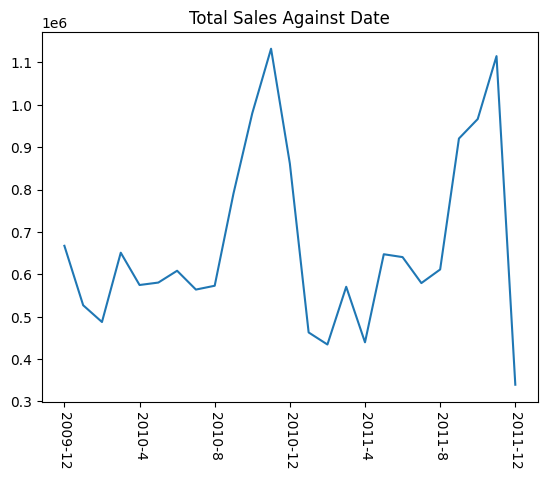

In [78]:
tmp = df.groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.title("Total Sales Against Date")
plt.xticks(rotation=-90)
plt.xticks(ticks=range(0, len(date_index), 4), labels=date_index[::4])
plt.plot(date_index, tmp.values)
plt.show()

We can see that spikes appear in the four quater of 2010 and 2011. The spikes maybe due to huge event or holiday like holloween or christmas. <br>
Next, let take a look at the popular products in fourth quarter

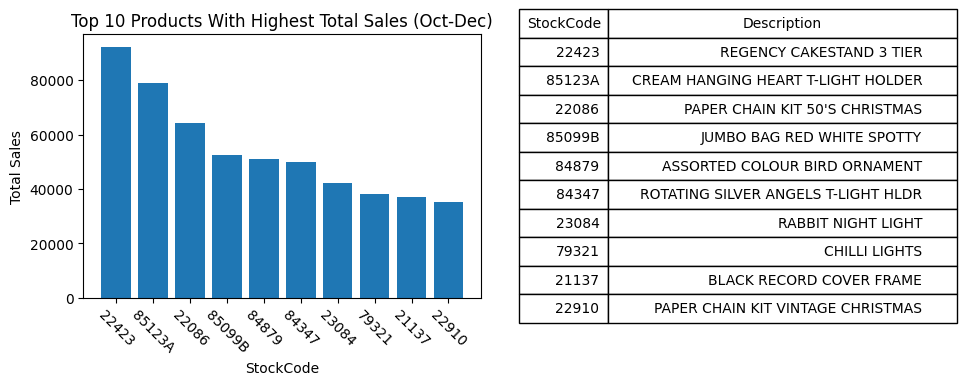

In [79]:
summary = df[df['Month']>=10].groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False).reset_index()
summary.rename(columns={'TotalPrice':'Total Sales'}, inplace=True)
tmp1 = df.groupby('StockCode')['Price'].idxmax().values
summary = pd.merge(summary, df[['StockCode', 'Description']].loc[tmp1], on='StockCode')
plot_top10_with_description(summary,'StockCode' , 'Total Sales', 'Total Sales', 'Top 10 Products With Highest Total Sales (Oct-Dec)')

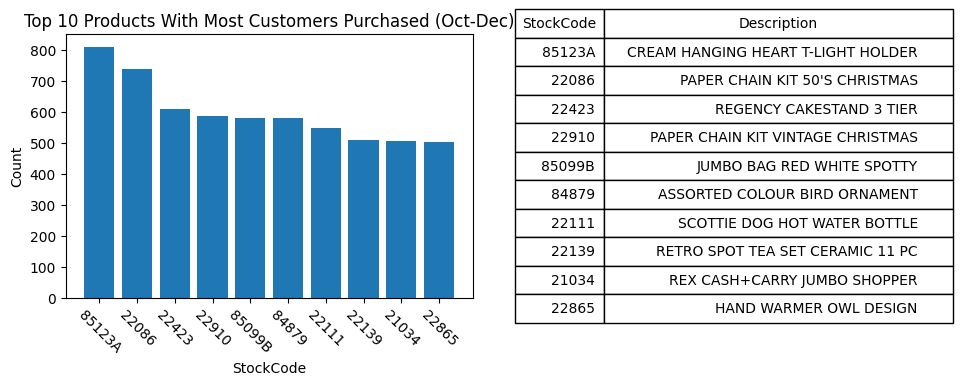

In [80]:
summary = df[df['Month']>=10].groupby(['StockCode', 'Customer ID'])['Quantity'].count().reset_index()
summary = summary.groupby('StockCode')['Customer ID'].count().sort_values(ascending=False).reset_index()
summary.rename(columns={'Customer ID':'# of Customers Purchased'}, inplace=True)
tmp1 = df.groupby('StockCode')['Price'].idxmax().values
summary = pd.merge(summary, df[['StockCode', 'Description']].loc[tmp1], on='StockCode')
plot_top10_with_description(summary,'StockCode' , '# of Customers Purchased', 'Count', 'Top 10 Products With Most Customers Purchased (Oct-Dec)')

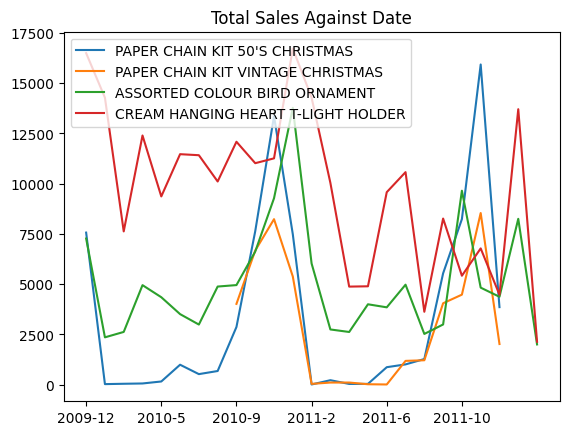

In [81]:
tmp = df[df['StockCode']=='22086'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.xticks(ticks=range(0, len(date_index), 4), labels=date_index[::4])
plt.plot(date_index, tmp.values, label=summary[summary['StockCode']=='22086']['Description'])
tmp = df[df['StockCode']=='22910'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.plot(date_index, tmp.values, label=summary[summary['StockCode']=='22910']['Description'])

tmp = df[df['StockCode']=='84879'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.plot(tmp.values, label=summary[summary['StockCode']=='84879']['Description'])

tmp = df[df['StockCode']=='85123A'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()

plt.plot(tmp.values, label=summary[summary['StockCode']=='85123A']['Description'])
plt.legend(loc='upper left')
plt.title("Total Sales Against Date")
plt.show()

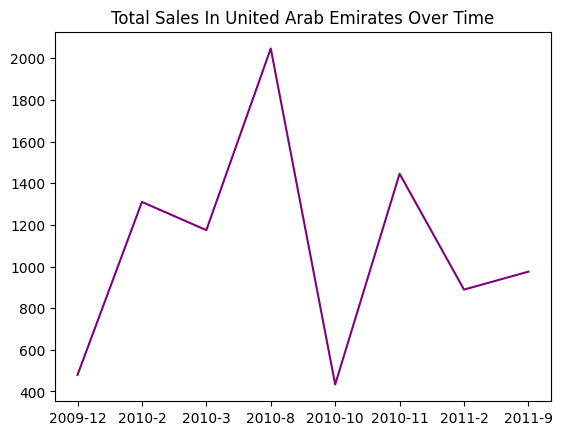

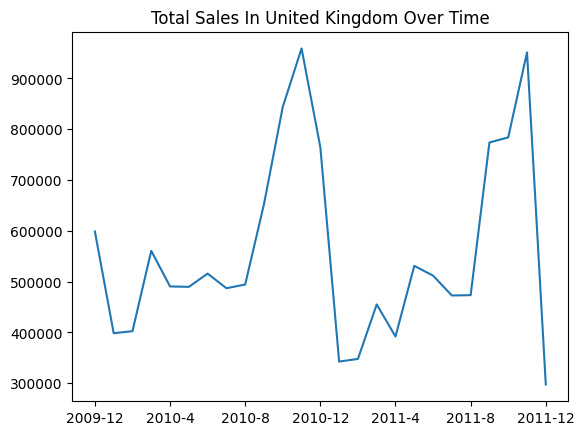

In [82]:
tmp = df[df['Country']=='United Arab Emirates'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.title("Total Sales In United Arab Emirates Over Time")
plt.plot(date_index, tmp.values, color='purple')
plt.show()
tmp = df[df['Country']=='United Kingdom'].groupby(by=['Year', 'Month'])['TotalPrice'].sum()
date_index = tmp.index.map(lambda x: "-".join(map(str, x))).to_list()
plt.xticks(ticks=range(0, len(date_index), 4), labels=date_index[::4])
plt.title("Total Sales In United Kingdom Over Time")
plt.plot(date_index, tmp.values)
plt.show()

#### Summary

Here's a summary of the discoveries:
1. Customers are most likely to buy cheaper things than more expensive things
2. There exist some extreme cases which the transaction values are way larger than the average
3. Customers have decent chances to buy the same items again
4. Customers tend to buy products of similar prices in the same invoice
5. Customers will buy variances of items


## Prediction

In this section, we will build a model to predict the preference of customers. <br>
An user-base collaborative filtering model would be implemented. <br><br>

Cosine similarity is used to choose top 3 close-customers.

Before we start, let's preview the dataset that we have.

In [83]:
print(f"Number of records: {len(df)}")
print(f"Unique customers: {len(set(df['Customer ID'].unique()))}")
print(f"Unique products: {len(set(df['StockCode'].unique()))}")

Number of records: 791973
Unique customers: 5833
Unique products: 4591


Next, we transform the 'Customer ID' and 'StockCode' columns to number for the sake of easier computations.

In [84]:
label_customer = preprocessing.LabelEncoder()
label_customer.fit(df['Customer ID'])
df['Customer ID'] = label_customer.transform(df['Customer ID'])
label_product = preprocessing.LabelEncoder()
label_product.fit(df['StockCode'])
df['StockCode'] = label_product.transform(df['StockCode'])

Split the dataframe into train and test parts and feed to train data into the transaction matrix.

In [85]:
n_customer = len(df['Customer ID'].unique())
n_stockcode = len(df['StockCode'].unique())

In [86]:
train, test = train_test_split(df, test_size=0.2, random_state=1234)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

###### Collapse

In [87]:
transaction_matrix  = np.zeros((n_customer, n_stockcode))
for i in tqdm(range(len(train)), desc="Processing"):
    transaction_matrix[int(train.loc[i]['Customer ID']), int(train.loc[i]['StockCode'])] = 1

Processing:   0%|          | 0/633578 [00:00<?, ?it/s]

In [88]:
customers_matrix  = np.ones((n_customer, n_customer))*1e-4                 # prevent divide by 0
customers_length = np.sqrt(np.sum(transaction_matrix**2, axis=1))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i,:] = transaction_matrix.dot(transaction_matrix[i])/customers_length/np.sqrt(transaction_matrix[i].dot(transaction_matrix[i]))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i, i] = -1

Processing:   0%|          | 0/5833 [00:00<?, ?it/s]

C:\Users\marco\AppData\Local\Temp\ipykernel_33356\505451029.py:4: RuntimeWarning: invalid value encountered in divide
  customers_matrix[i,:] = transaction_matrix.dot(transaction_matrix[i])/customers_length/np.sqrt(transaction_matrix[i].dot(transaction_matrix[i]))


Processing:   0%|          | 0/5833 [00:00<?, ?it/s]

In [89]:
prediction_matrix = transaction_matrix*-1
for cid in tqdm(range(n_customer)):
    for close_cid in pd.Series(customers_matrix[cid]).sort_values(ascending=False).index[:3]:
        prediction_matrix[cid] += transaction_matrix[close_cid]-transaction_matrix[cid]

  0%|          | 0/5833 [00:00<?, ?it/s]

In [90]:
test['Prediction'] = test.apply(lambda x: prediction_matrix[x['Customer ID'], x['StockCode']], axis=1)
test['Prediction'] = test['Prediction'].map({3:'a3', 2:'a2', 1:'a1', 0:'N', -1:'A', -2:'b1', -3:'b2', -4:'b3'})

######

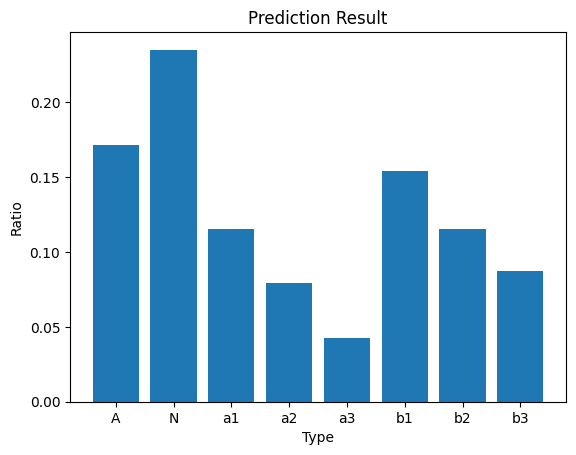

In [91]:
tmp = test.groupby('Prediction')['Customer ID'].count()
plt.bar(x=tmp.index, height=tmp.values/tmp.sum())
plt.title('Prediction Result')
plt.ylabel('Ratio')
plt.xlabel('Type')
plt.show()

Here's an explanation to the types, the customers have bought the items in the test set, <br>
given that in the train set,
- A : The customer and all of his close-customers bought the product
- N : Neither the customer nor his close-customers bought
- a(n) : The customer haven't bought the product, but (n) of his close-customers had done so
- b(n) : The customer have bought the product, but (n) of his close-customers hadn't done so

In [92]:
print(f"(a1~3)/(a1~3 + N) = {round(tmp[['a1', 'a2', 'a3']].sum()/tmp[['a1', 'a2', 'a3', 'N']].sum()*100, 2)}%")

(a1~3)/(a1~3 + N) = 50.22%


N and a1~3 are types that would be considered when recommending products to customers. <br>
A and b1~3 are types which the customers have already bought the items. <br><br>
a1~3 are the types that would be recommended to customers (ignore b1~3 and A for this moment), <br> 
if consider a1~3 and N only, they add up to ~50%, <br>
indicating that the recommended items would be bought in 50% of time, which sounds not good. <br>
however, in the EDA part, we calculated that a customer bought ~82 different products on average, <br>
meanwhile there are 4600+ products in the dataset. <br>
50% is actually quite good.


Now we have the whole dataset involved:

###### Collapse

In [93]:
transaction_matrix  = np.zeros((n_customer, n_stockcode))
for i in tqdm(range(len(df)), desc="Processing"):
    transaction_matrix[int(df.loc[i]['Customer ID']), int(df.loc[i]['StockCode'])] = 1

Processing:   0%|          | 0/791973 [00:00<?, ?it/s]

In [94]:
customers_matrix  = np.ones((n_customer, n_customer))*1e-4                 # prevent divide by 0
customers_length = np.sqrt(np.sum(transaction_matrix**2, axis=1))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i,:] = transaction_matrix.dot(transaction_matrix[i])/customers_length/np.sqrt(transaction_matrix[i].dot(transaction_matrix[i]))
for i in tqdm(range(n_customer), desc="Processing"):
    customers_matrix[i, i] = -1

Processing:   0%|          | 0/5833 [00:00<?, ?it/s]

Processing:   0%|          | 0/5833 [00:00<?, ?it/s]

In [95]:
prediction_matrix = transaction_matrix*-1
for cid in tqdm(range(n_customer)):
    for close_cid in pd.Series(customers_matrix[cid]).sort_values(ascending=False).index[:3]:
        prediction_matrix[cid] += transaction_matrix[close_cid]-transaction_matrix[cid]

  0%|          | 0/5833 [00:00<?, ?it/s]

In [96]:
tmp2 = df.apply(lambda x: prediction_matrix[x['Customer ID'], x['StockCode']], axis=1)
tmp2 = tmp2.map({3:'a3', 2:'a2', 1:'a1', 0:'N', -1:'A', -2:'b1', -3:'b2', -4:'b3'})

######

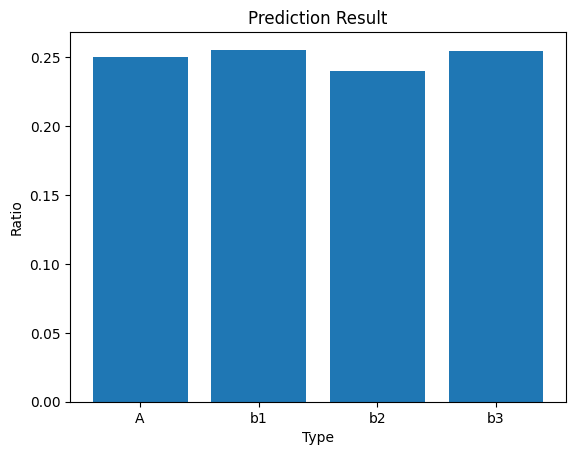

In [97]:
tmp = tmp2.groupby(by=tmp2.values).count()
plt.bar(x=tmp.index, height=tmp.values/tmp.sum())
plt.title('Prediction Result')
plt.ylabel('Ratio')
plt.xlabel('Type')
plt.show()

Here's an explanation to the types, in the dataset,
- A : The customer and all of his close-customers bought the product
- b(n) : The customer have bought the product, but (n) of his close-customers hadn't done so

The ratio of each type is quite balanced. <br>
for ~75% (1-b3) of time, the items which are bought by customers can also be found in their close-customers' records, <br>
indicating strong correlations between customers' preferences.




## Future Enhancement

1. This project focused on the Customer ID and StockCode. The Country and Date Columns could also be utilized to build more sophisticated models.
2. An item-base collaborative filtering model can be used to better analyse the relationships between different products.